<a href="https://colab.research.google.com/github/FrnNardes/Top-Insta-Influencers---Linear-Regression/blob/main/LinearRegressionRESTIC36.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando bibliotecas e adicionando arquivo csv


In [60]:
import pandas as pd
from google.colab import files

# Fazer upload do arquivo
print("Por favor, faça o upload do arquivo CSV.")
uploaded = files.upload()

# Exibir os nomes dos arquivos carregados
for filename in uploaded.keys():
    print(f"Arquivo carregado: {filename}")

# Coloca na variável file_path o primeiro arquivo carregado e lê o CSV
file_path = list(uploaded.keys())[0]
df = pd.read_csv(file_path)


Por favor, faça o upload do arquivo CSV.


Saving top_insta_influencers_data.csv to top_insta_influencers_data (5).csv
Arquivo carregado: top_insta_influencers_data (5).csv


**Analise Exploratória de Dados (EDA)**

In [61]:
df.head()

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States
2,3,leomessi,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b,NaN
3,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States
4,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rank               200 non-null    int64 
 1   channel_info       200 non-null    object
 2   influence_score    200 non-null    int64 
 3   posts              200 non-null    object
 4   followers          200 non-null    object
 5   avg_likes          200 non-null    object
 6   60_day_eng_rate    200 non-null    object
 7   new_post_avg_like  200 non-null    object
 8   total_likes        200 non-null    object
 9   country            138 non-null    object
dtypes: int64(2), object(8)
memory usage: 15.8+ KB


**Convertendo os prefixos 'k', 'm', 'b', '%' para suas respectivas representações numéricas**

In [63]:
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'k' in value:
            return float(value.replace('k', '')) * 1e3
        elif 'm' in value:
            return float(value.replace('m', '')) * 1e6
        elif 'b' in value:
            return float(value.replace('b', '')) * 1e9
        elif '%' in value:
            return float(value.replace('%', '')) / 100
    return value

df['new_post_avg_like'] = df['new_post_avg_like'].replace('0', np.nan)

columns_to_convert = ['posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes']
for col in columns_to_convert:
    df[col] = df[col].apply(convert_to_numeric)

# Verificar o resultado das conversões
df[columns_to_convert].head()

,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
0,3300.0,475800000.0,8700000.0,0.0139,6500000.0,2.900000e+10
1,6900.0,366200000.0,8300000.0,0.0162,5900000.0,5.740000e+10
2,890.0,357300000.0,6800000.0,0.0124,4400000.0,6.000000e+09
3,1800.0,342700000.0,6200000.0,0.0097,3300000.0,1.150000e+10
4,6800.0,334100000.0,1900000.0,0.0020,665300.0,1.250000e+10


**Algumas estatisticas gerais de cada coluna**

In [64]:
print(df.describe())
print(df.info())

             rank  influence_score         posts     followers     avg_likes  \
count  200.000000       200.000000    200.000000  2.000000e+02  2.000000e+02   
mean   100.500000        81.820000   3499.850000  7.740950e+07  1.787104e+06   
std     57.879185         8.878159   3475.828158  7.368727e+07  2.193359e+06   
min      1.000000        22.000000     10.000000  3.280000e+07  6.510000e+04   
25%     50.750000        80.000000    947.500000  4.000000e+07  5.044000e+05   
50%    100.500000        84.000000   2100.000000  5.005000e+07  1.100000e+06   
75%    150.250000        86.000000   5025.000000  6.890000e+07  2.100000e+06   
max    200.000000        93.000000  17500.000000  4.758000e+08  1.540000e+07   

       60_day_eng_rate  new_post_avg_like   total_likes  
count       199.000000       1.920000e+02  2.000000e+02  
mean          0.019020       1.258471e+06  3.658112e+09  
std           0.033297       1.879979e+06  5.561939e+09  
min           0.000100       7.700000e+03  1.83

*Havia um valor = '0' fazendo com que 'new_post_avg_like' ficasse com o tipo object, então transformei o valor em NaN, para ser removido posteriormente no codigo*

In [65]:
df['new_post_avg_like'].unique()

array([6.500e+06, 5.900e+06, 4.400e+06, 3.300e+06, 6.653e+05, 2.900e+06,
       3.900e+06, 2.000e+06, 9.269e+05, 1.500e+06, 5.100e+06, 1.593e+05,
       1.818e+05, 2.300e+06, 1.400e+06, 1.000e+06, 1.300e+06, 9.136e+05,
       1.900e+06, 2.651e+05, 1.152e+05, 4.800e+06, 3.634e+05,       nan,
       1.200e+06, 8.170e+04, 5.883e+05, 2.559e+05, 7.063e+05, 5.200e+06,
       1.100e+06, 5.865e+05, 4.823e+05, 8.029e+05, 7.200e+06, 3.047e+05,
       1.258e+05, 3.409e+05, 8.599e+05, 2.980e+04, 1.600e+06, 3.701e+05,
       1.969e+05, 5.700e+06, 2.100e+06, 7.300e+06, 3.257e+05, 3.600e+06,
       3.390e+05, 1.894e+05, 3.666e+05, 4.262e+05, 6.963e+05, 6.249e+05,
       7.188e+05, 3.222e+05, 6.000e+06, 2.416e+05, 3.231e+05, 2.486e+05,
       4.483e+05, 5.000e+06, 9.189e+05, 4.626e+05, 8.371e+05, 1.076e+05,
       1.355e+05, 2.665e+05, 6.939e+05, 3.013e+05, 5.316e+05, 9.717e+05,
       5.579e+05, 3.405e+05, 5.630e+04, 7.742e+05, 1.680e+04, 6.112e+05,
       6.044e+05, 3.639e+05, 4.529e+05, 1.260e+07, 

**Matriz de correlação**

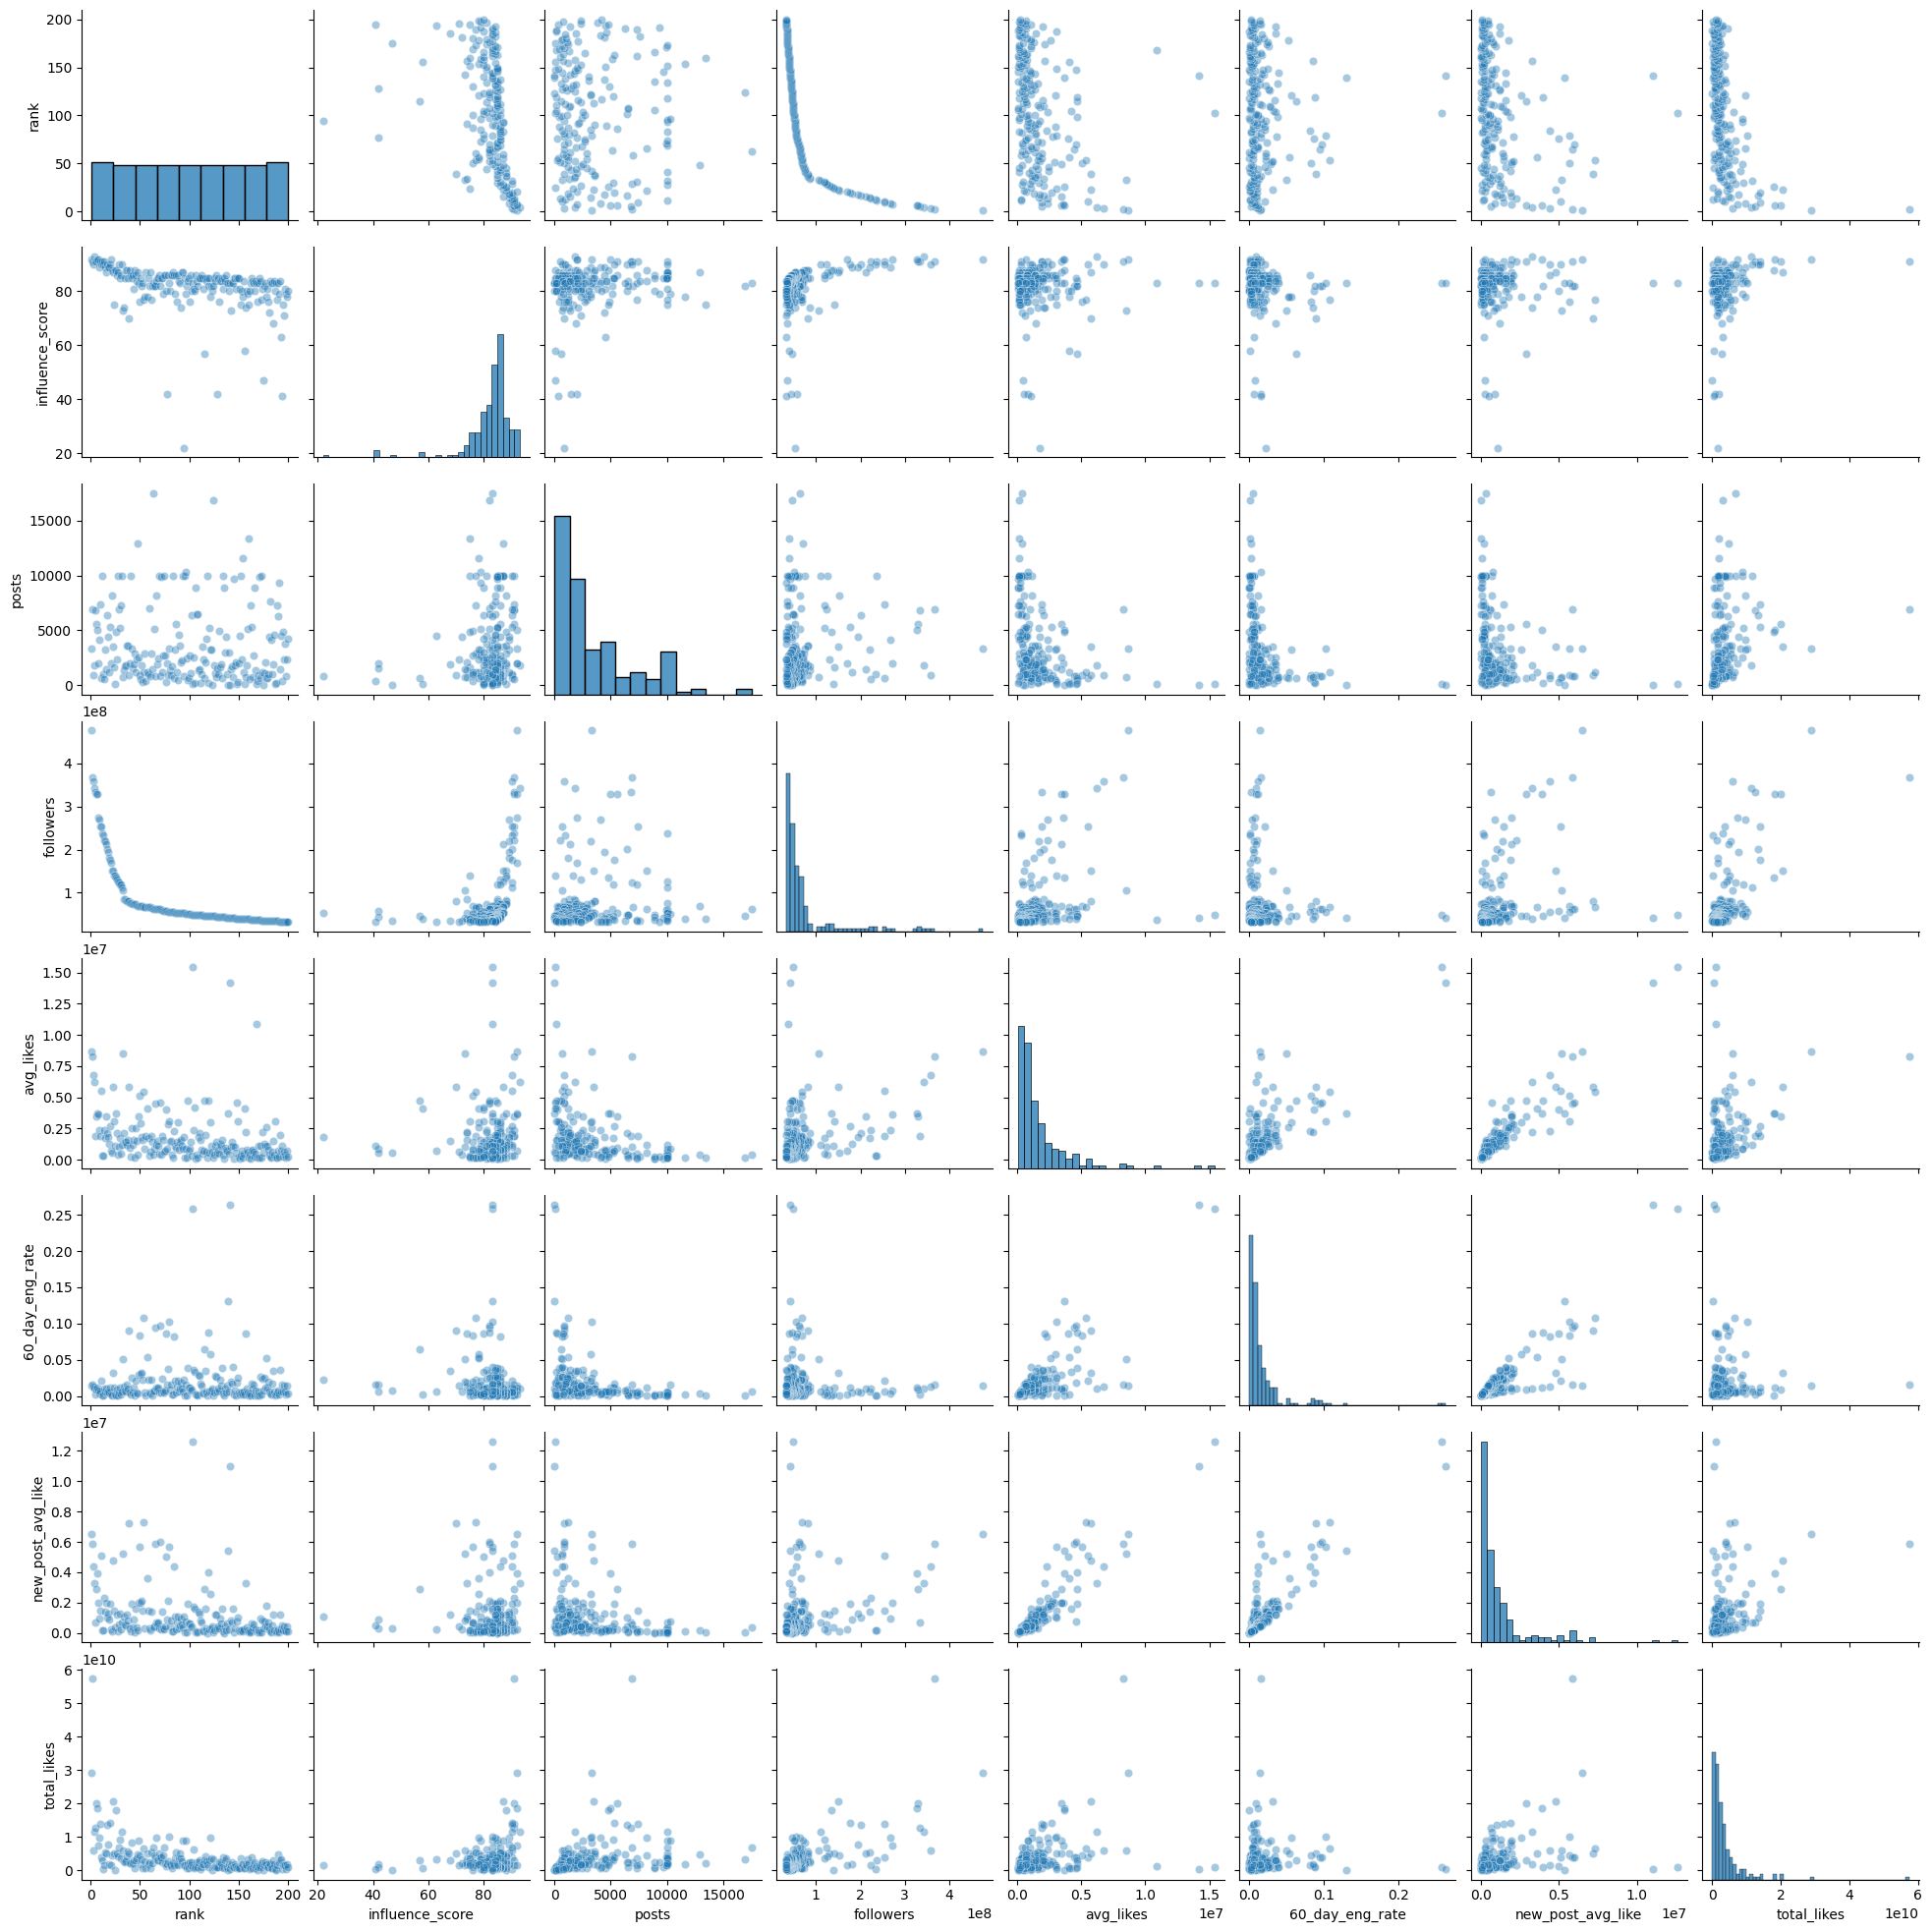

In [66]:
import seaborn as sns

sns.pairplot(df, kind='scatter', plot_kws={'alpha' : 0.4})


**Removendo alguns outliers**

---


*Fiz diversos testes, e o que obtive a maior precisao foi fazendo IQR apenas na coluna '60_day_eng_rate', 'influence_score' e na variavel dependende de followers, pois a alguns valores muito descrepantes com a tendencia*

In [67]:
# Colunas utilizadas no processo
numerical_features = ['60_day_eng_rate', 'followers']

# Iteração
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Limites inferior e superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtra o DataFrame, removendo os outliers da coluna atual
    df_filtered = df_filtered[(df_filtered[feature] >= lower_bound) & (df_filtered[feature] <= upper_bound)]

# Reseta o índice do DF
df_filtered = df_filtered.reset_index(drop=True)

**Matriz de Correlação após IQR**

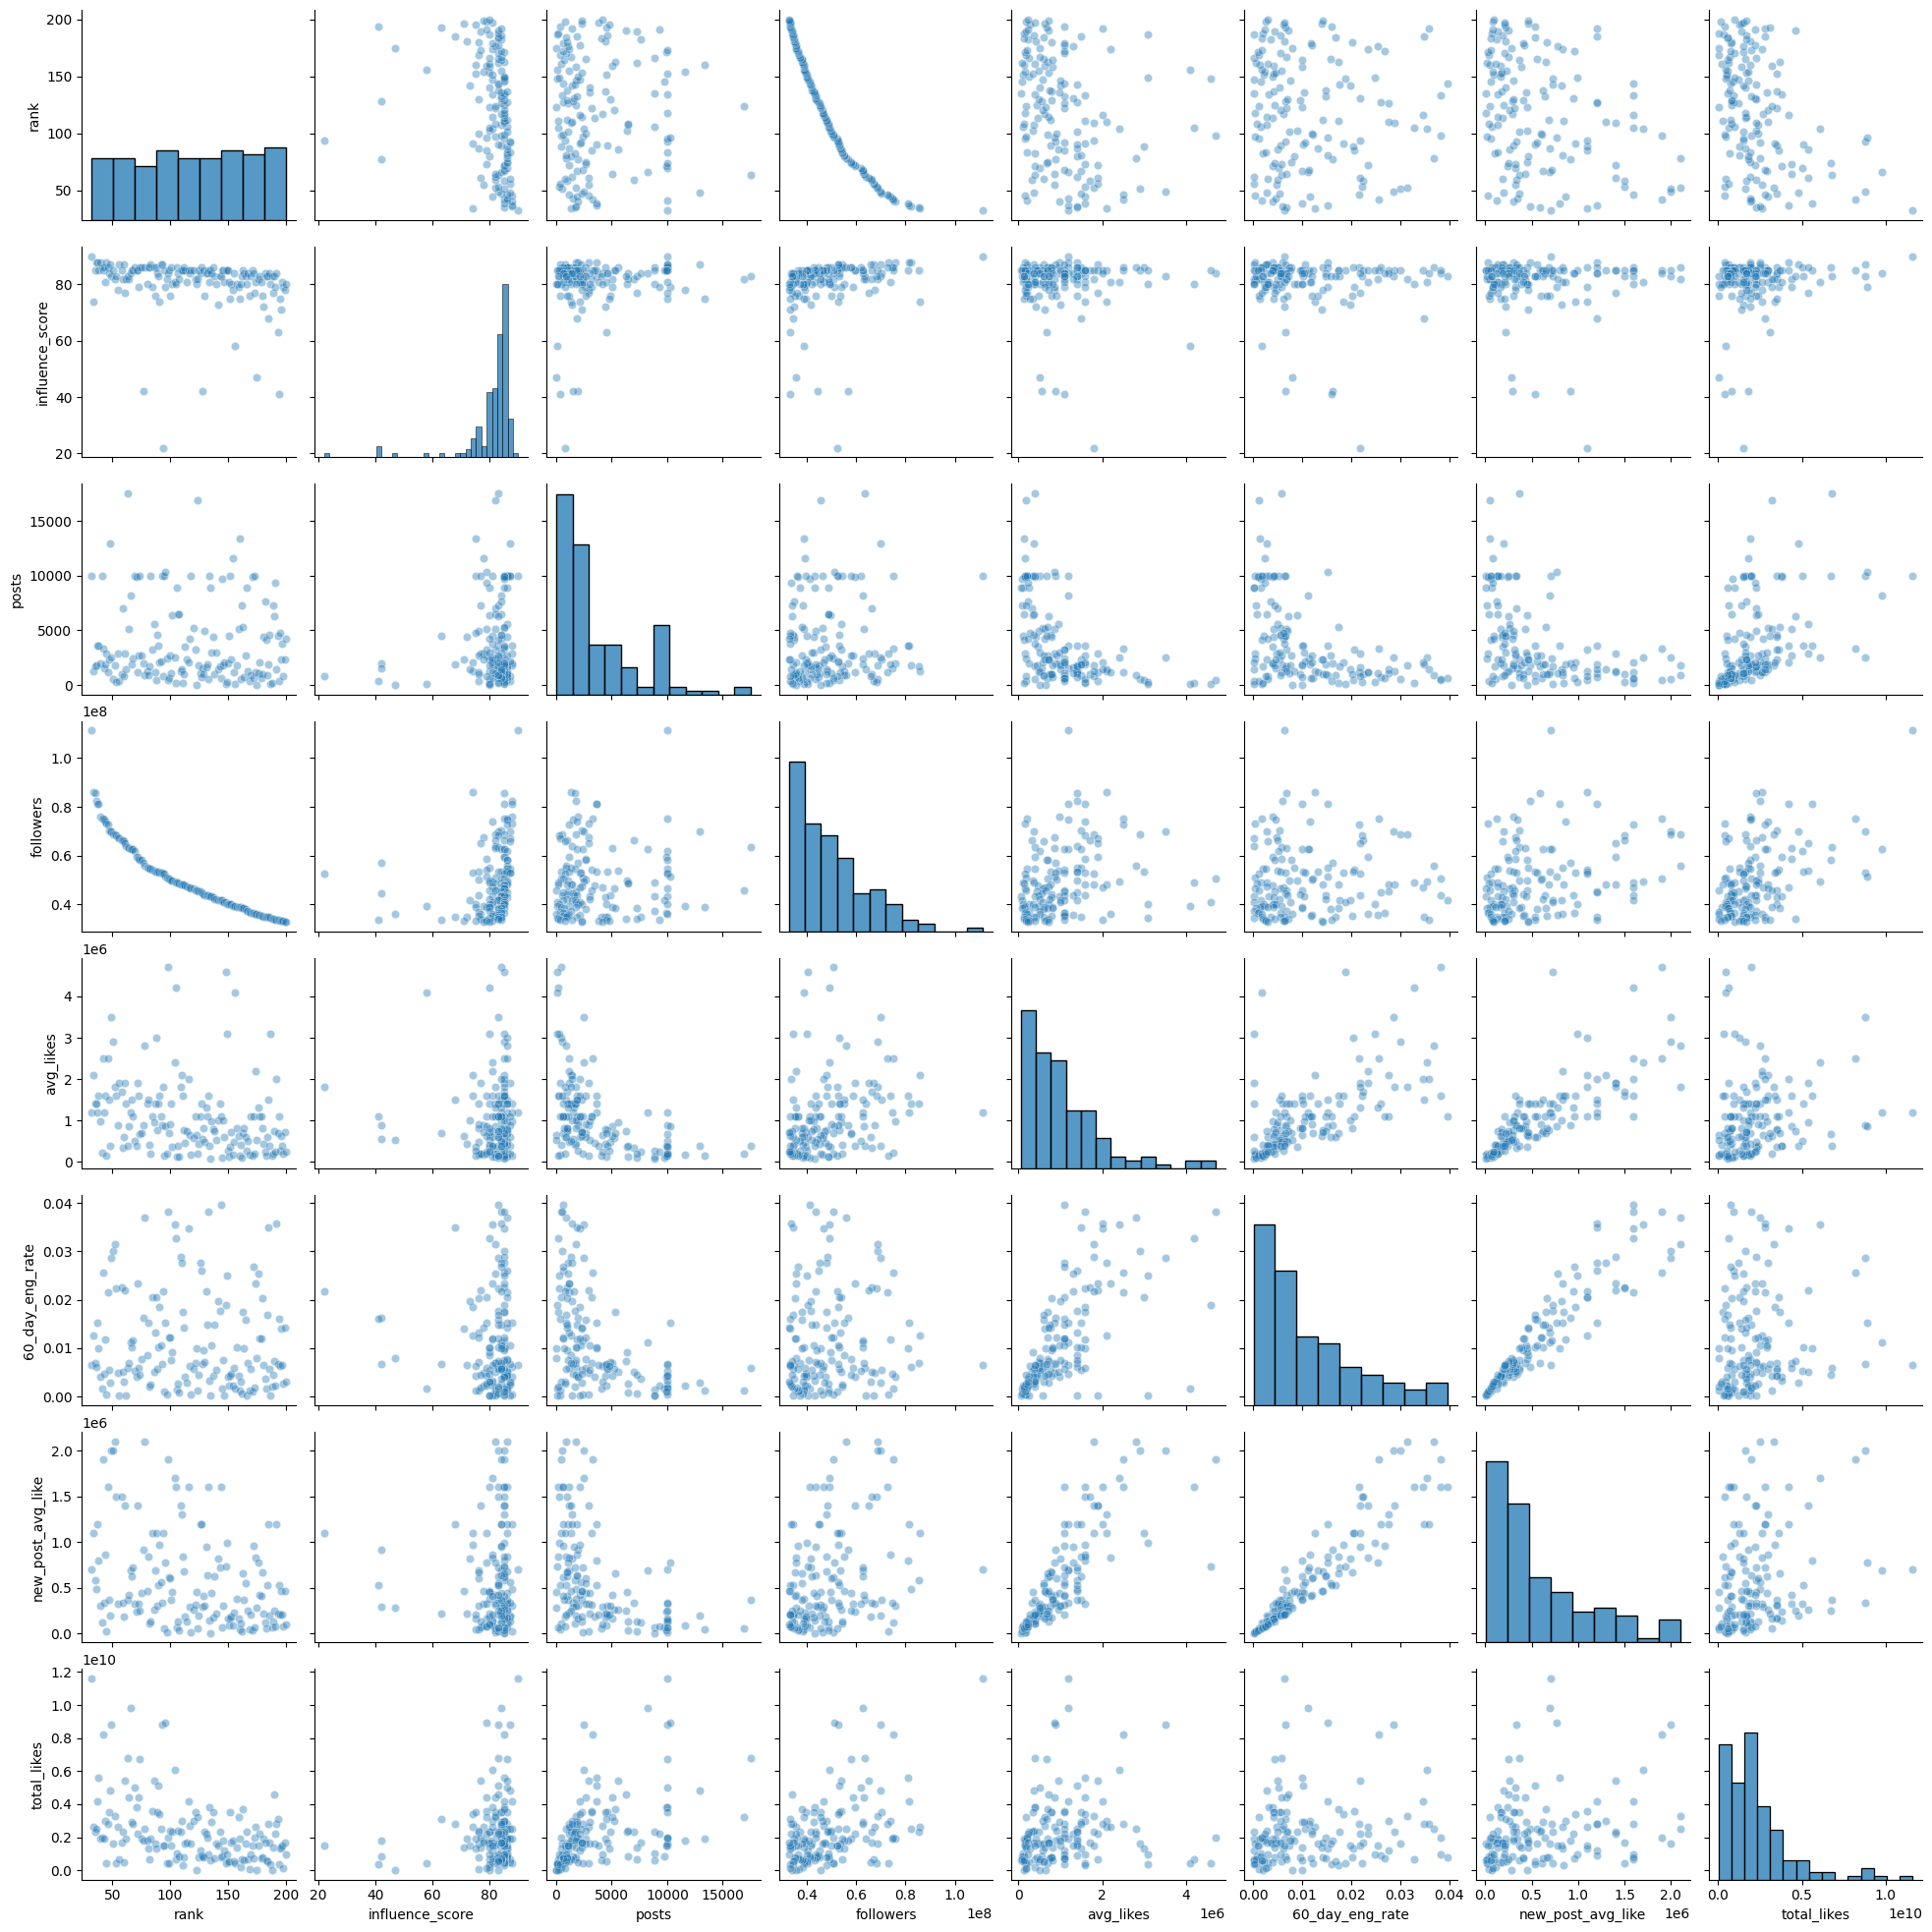

In [68]:
sns.pairplot(df_filtered, kind='scatter', plot_kws={'alpha' : 0.4})

**Rodando o modelo de regressão linear**

In [69]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Selecionar features e variável alvo
features = ['posts', 'avg_likes', '60_day_eng_rate','new_post_avg_like','total_likes', 'influence_score']
target = 'followers'

# Remover valores NaN
df_clean = df_filtered[features + [target]].dropna()

# Dividir em conjuntos de treino e teste
X = df_clean[features]
y = df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e aplicar o StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar o modelo de regressão linear com dados escalados
model = LinearRegression(fit_intercept=True, copy_X=True, positive=False)
model.fit(X_train_scaled, y_train)

# Prever no conjunto de teste escalado
y_pred = model.predict(X_test_scaled)

# Avaliar o modelo
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calcular o RMSE usando validação cruzada
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# Imprimir os resultados
print("R2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
print('-----------------------')
print(f"RMSE médio: {rmse_scores.mean():.2f}")
print(f"Desvio padrão do RMSE: {rmse_scores.std():.2f}")
print('-----------------------')
print(f"Obtemos um R² de {r2*100}%, o que significa que o modelo explica ~60% da variação nos dados. E nosso RMSE = {rmse} mostra que o modelo erra em média ~9 milhões de unidades e um MAE de ~6 milhoes. Considerando o alto valor de seguidores dos influenciadores, este valor fica aceitavel.")

R2: 0.5971149960433006
RMSE: 8651064.925768944
MAE: 6324606.584426997
-----------------------
RMSE médio: 8978094.80
Desvio padrão do RMSE: 800484.90
-----------------------
Obtemos um R² de 59.711499604330065%, o que significa que o modelo explica ~70% da variação nos dados. E nosso RMSE = 8651064.925768944 mostra que o modelo erra em média ~7 milhões de unidades e um MAE de ~5 milhoes. Considerando o alto valor de seguidores dos influenciadores, este valor fica aceitavel.


**Plotando as relações**


---


*Como temos mais de 3 dimensoes, não podemos visualiza-las em conjunto, mas podemos plotar as relações de cada uma com a variavel dependente e sua reta de regressão linear*

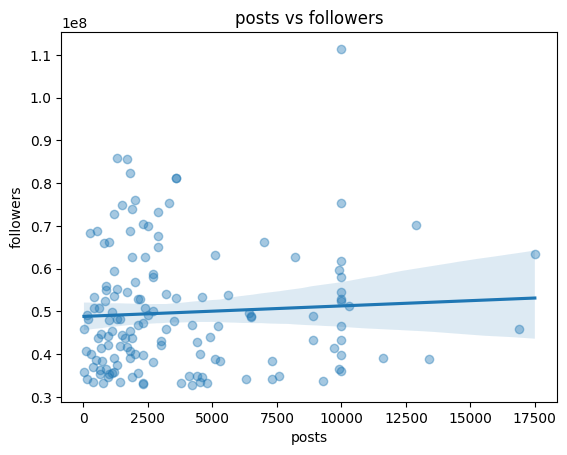

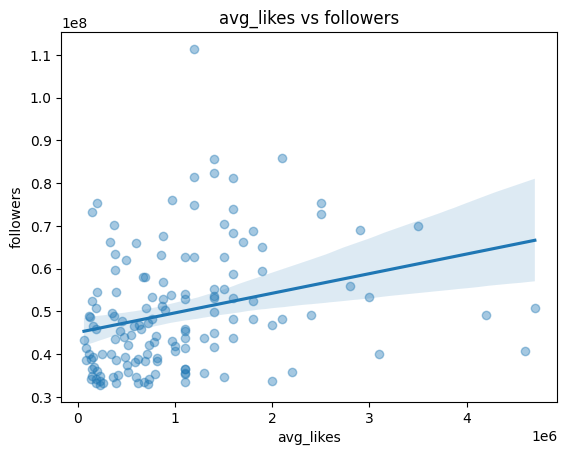

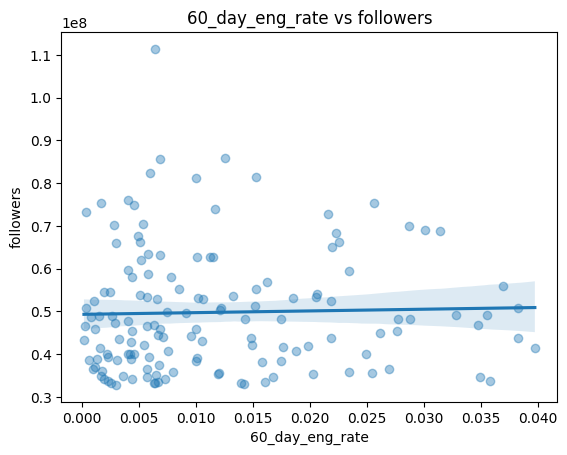

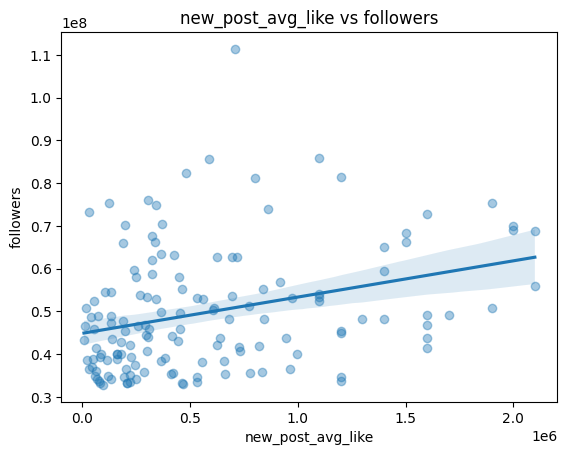

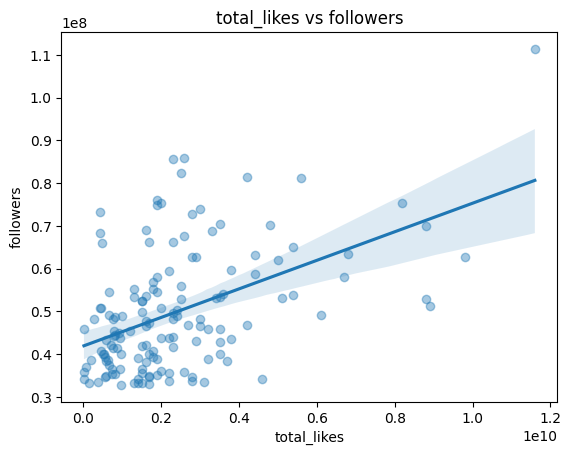

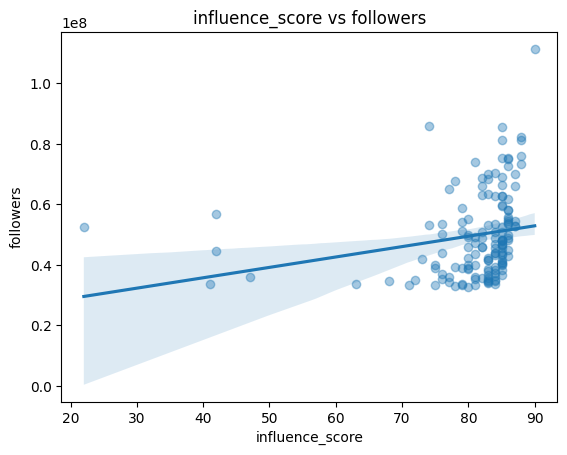

In [70]:
import matplotlib.pyplot as plt

for feature in features:
    sns.regplot(x=feature, y=target, data=df_clean, scatter_kws={'alpha': 0.4})
    plt.title(f'{feature} vs {target}')
    plt.show()